# How different weather conditions induce forest fires in Algeria

# Introduction

Climate change is causing changes in weather conditions that have the potential of inducing forest fires around the world. Located on the Mediterranean coast, Algeria houses several endangered species, like the prickly juniper. However, because Algeria's hot, dry climate increases the rate of evaporation, plants are drier than usual, and, consequently, increase the occurrence of forest fires. Thus, it is important to combat this environmental issue to prevent further decimation and degradation of Algerian forests. 

Focusing on the Bejaia region from the Algerian Forest Fires dataset, which contains numerical data on relative humidity, wind speed, rain, and temperature, we will use the aforementioned variables as predictors to evaluate their predictive values and determine how well they predict the occurrence of forest fires in Bejaia. 

# Methods and Results

## **NEW**
- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- your report should include code which:
     - loads data from the original source on the web 
     - wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
     - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
     - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
     - performs the data analysis
     - creates a visualization of the analysis 
     - note: all tables and figure should have a figure/table number and a legend


#### **From methods section in proposal**

- We will be using the K-nearest neighbour classification system, with predictors: relative humidity, wind speed, rain, and temperature, to classify new observations as "fire" or "not fire". 

    - First, we split the data set into a training set and a testing set. Then, the training set is further split into a training set and a validation set so that we can tune our model and perform a 5-fold cross-validation to choose a K-value that gives the most accurate predictions. 

    - Additionally, we will standardize the data, by scaling and centering the data so the average will be 0 and the standard deviation will be 1, to ensure all variables are on a comparable scale to contribute equally in the calculation of the distance between the points. 

    - In general, for each predictor we:
        - calculate the Euclidean distance between the new observation and each observation in the training set, 
        - place the distances in ascending order, 
        - classify the new observation to a class 


- Results will be visualized with a 4x4 group of scatterplots (and their respective distributions), where points are coloured by classes, and, therefore, will show the relationships between each variable.


In [32]:
# Loading packages
library(dplyr)
library(repr)
library(tidyverse)
library(tidymodels)
library(GGally)
library(cowplot)

Warning message:
“package ‘cowplot’ was built under R version 4.0.3”


## Exploratory Data Analysis

In [2]:
# Reading and tidying data from the web

# read .csv file
algerian_fire <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", skip = 1)

# select the Bajaia region data and set up the right labels
bejaia_fire_0 <- algerian_fire[c(1:122), ]
bejaia_fire <- bejaia_fire_0 %>% 
                 select(day, month, year, Classes, Temperature, RH, Ws, Rain) %>%
                 mutate(Temperature = as.numeric(Temperature)) %>%
                 mutate(RH = as.numeric(RH)) %>%
                 mutate(Ws = as.numeric(Ws)) %>%
                 mutate(Rain = as.numeric(Rain)) 

# combine three columns and set it as date
bejaia_fire$date <- as.Date(with(bejaia_fire, paste(year, month, day, sep="-")), "%Y-%m-%d") 

# tidy the whole dataset
bejaia_fire_tidy <- bejaia_fire %>% 
                    select(date, Classes,Temperature, RH, Ws, Rain)

In [3]:
# Creating the training dataset

# remove space before and after the string
bejaia_fire_tidy$Classes <- trimws(bejaia_fire_tidy$Classes)

# set the label back to factor
bejaia_fire_tidy <- bejaia_fire_tidy %>% 
                    mutate(Classes = as.factor(Classes)) 

# split and get training and testing dataset
bejaia_split <- initial_split(bejaia_fire_tidy, prop = 0.75, strata = Classes)
bejaia_train <- training(bejaia_split)
bejaia_test <- testing(bejaia_split)

In [10]:
# Creating a table for the number of observations for each class

set.seed(80)

bejaia_table <- bejaia_train %>%
                group_by(Classes)%>%
                summarize(n = n())

'Table 1: Number of Observations for Each Class'
bejaia_table

`summarise()` ungrouping output (override with `.groups` argument)



[1] "Table 1: Number of Observations for Each Class"

Classes,n
<fct>,<int>
fire,45
not fire,48


In [5]:
# Preparing the training data for visualization

# preprocess and standardize data by centering and scaling
bejaia_recipe <- recipe(Classes ~ Temperature + RH + Ws + Rain, data = bejaia_train) %>% 
                 step_center(all_predictors()) %>%
                 step_scale(all_predictors())

# apply trained data recipe
bejaia_scaled <- bejaia_recipe %>%  
                 prep() %>%
                 bake(bejaia_train)

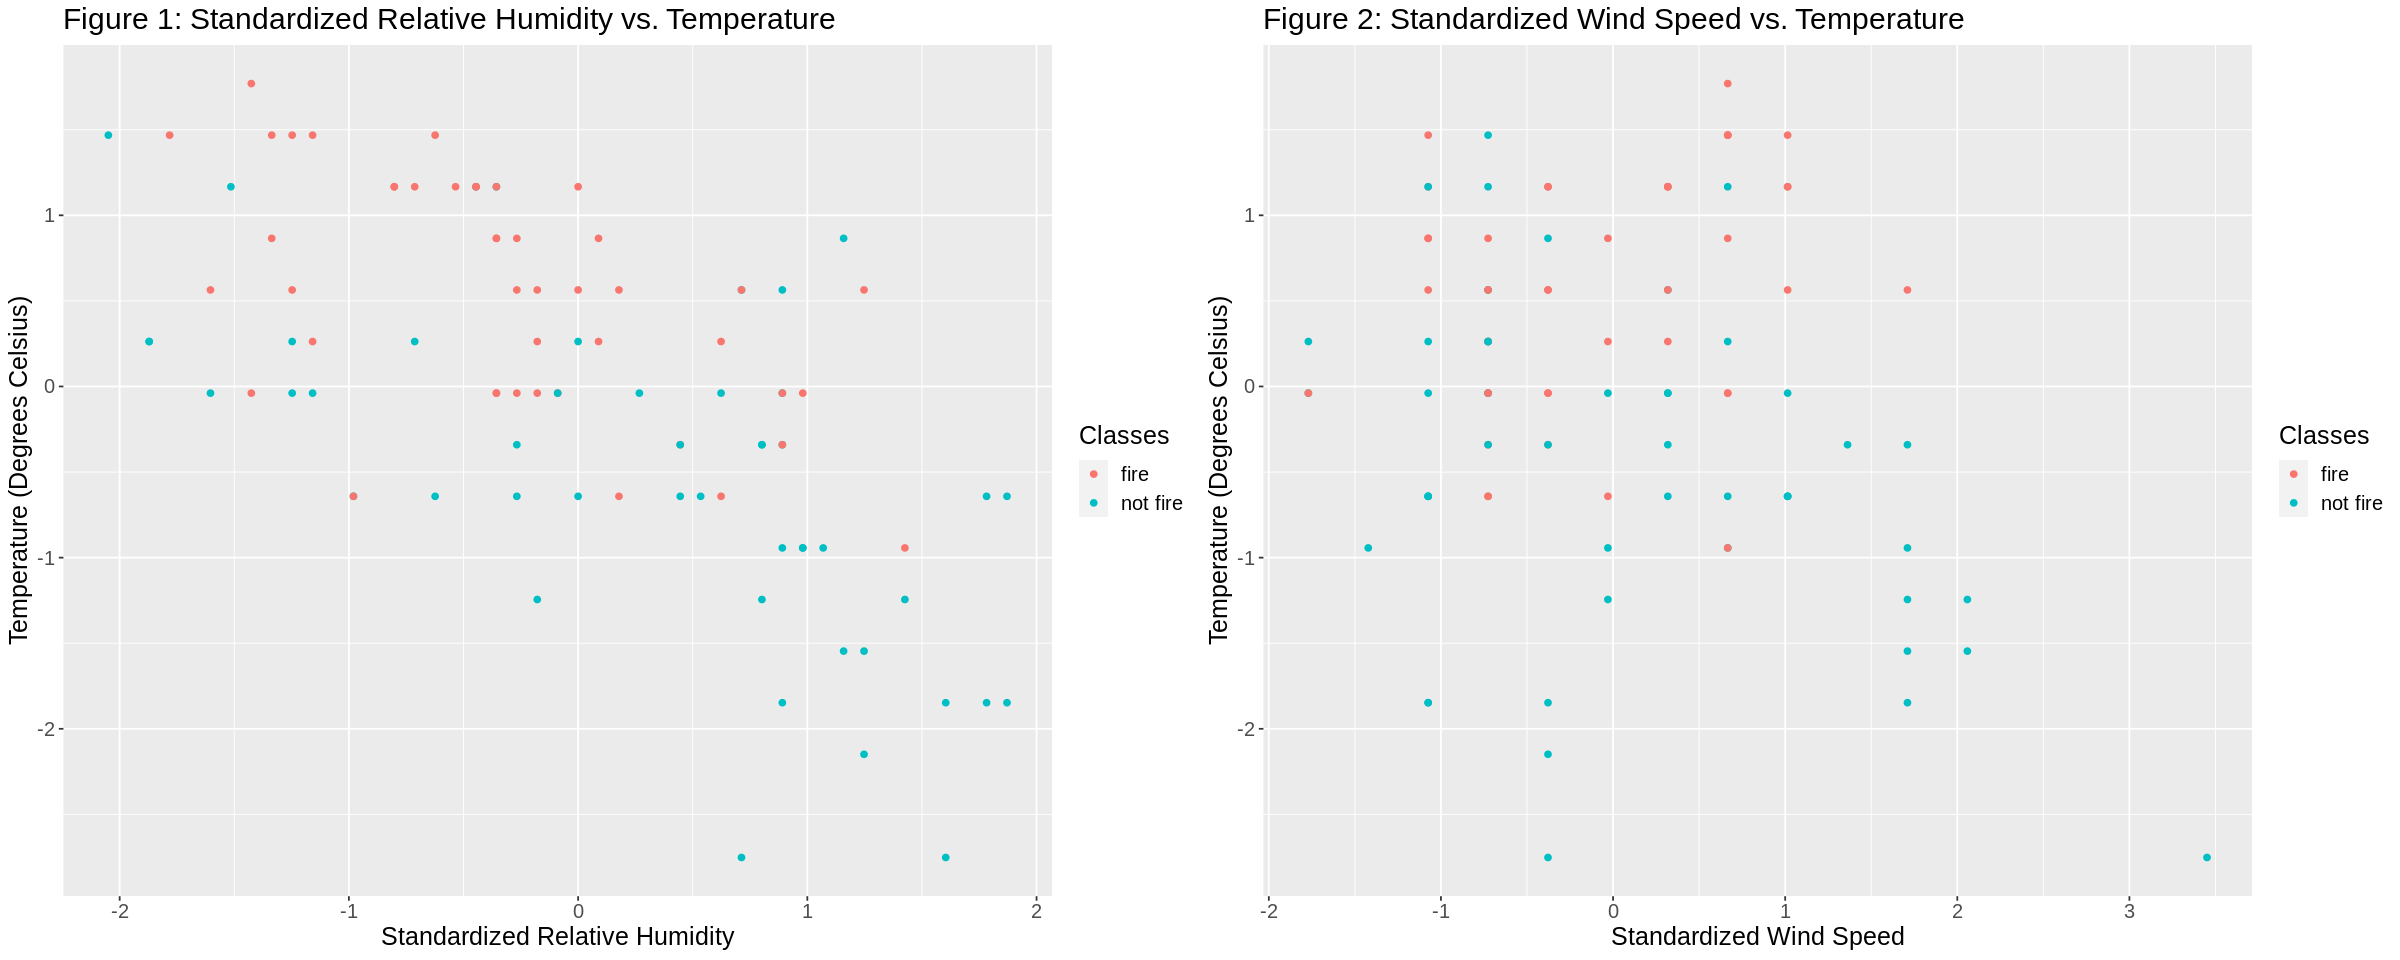

In [40]:
# The exploratory visualization 

options(repr.plot.width = 20, repr.plot.height = 8)

# Standardized Relative Humidity vs. Temperature plot
b_RH_plot <- bejaia_scaled %>% 
             ggplot(aes(x = RH, y = Temperature, color = Classes)) + 
             geom_point() + 
             ggtitle("Figure 1: Standardized Relative Humidity vs. Temperature") +
             labs(x = "Standardized Relative Humidity", y = "Temperature (Degrees Celsius)", colour = "Classes")+
             theme(text = element_text(size = 15))

# Standardized Wind Speed vs. Temperature plot
b_Ws_plot <- bejaia_scaled %>% 
             ggplot(aes(x = Ws, y = Temperature, color = Classes)) + 
             geom_point() + 
             ggtitle("Figure 2: Standardized Wind Speed vs. Temperature") +
             labs(x = "Standardized Wind Speed", y = "Temperature (Degrees Celsius)", colour = "Classes") +
             theme(text = element_text(size = 15))

plot_grid(b_RH_plot, b_Ws_plot)

In Figure 1, we can see that almost all fires occur when the temperature is above 0.5 degrees celsius and when the standardized relative humidity is below 1. From this, we can see that temperature and relative humidity are good predictors.

In Figure 2, we can see that most fires occur when temperatures are above 0.5 degrees celsius. However, wind speed does not appear to be a good predictor as there's no general statement that can be made. Therefore, like Figure 1, temperature can be seen as a good predictor.

In [ ]:
# The final visualization

options(repr.plot.width = 12, repr.plot.height = 12)

pairs_bejaia <- bejaia_train %>%
                select(Temperature, RH, Ws, Rain) %>%
                ggpairs(ggplot2::aes(colour = bejaia_train$Classes)) 
pairs_bejaia

# Data Analysis

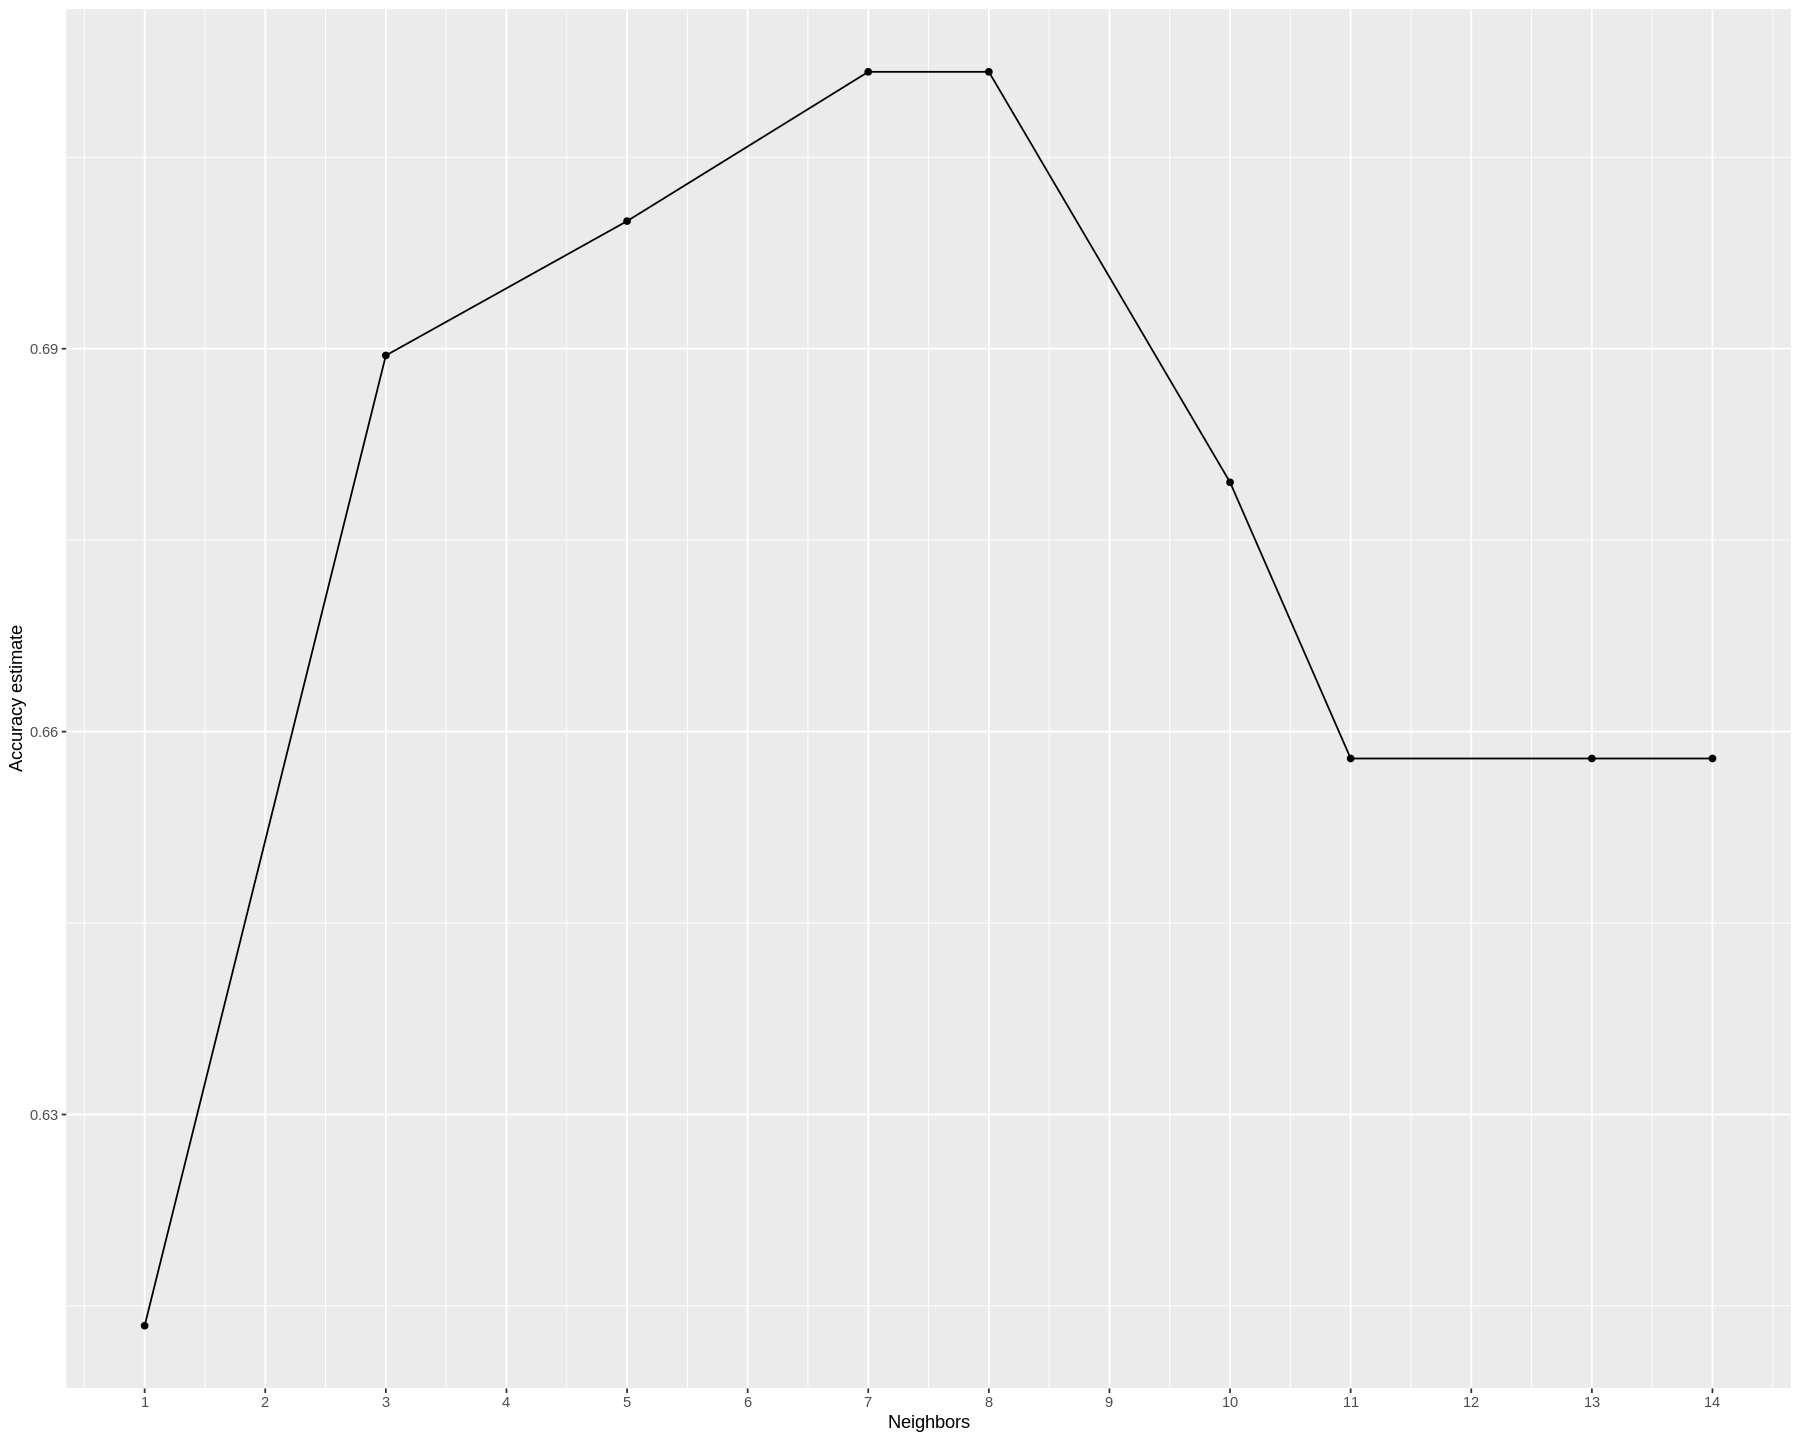

In [44]:
# Finding the best K

set.seed(80)  # because of cross-validation, we need to set a seed to prevent getting a different plot everytime

bejaia_recipe_1 <- recipe(Classes ~ Temperature + RH + Ws + Rain, data = bejaia_train) %>% 
                 step_center(all_predictors()) %>%
                 step_scale(all_predictors())

bejaia_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

bejaia_vfold <- vfold_cv(bejaia_train, v = 5, strata = Classes)

bejaia_workflow <- workflow() %>%
            add_recipe(bejaia_recipe) %>%
            add_model(bejaia_spec) %>%
            tune_grid(resamples = bejaia_vfold, grid = 10) %>%
            collect_metrics()

bejaia_accuracy <- bejaia_workflow %>% 
                filter(.metric == "accuracy")

options(repr.plot.width = 15, repr.plot.height = 12)

accuracy_plot <- bejaia_accuracy %>% 
                ggplot(aes(x = neighbors, y = mean)) + 
                geom_point() + 
                geom_line() + 
                xlab("Neighbors") + 
                ylab("Accuracy estimate") +
                scale_x_continuous(breaks = seq(0, 14, by = 1))   # adjusting the x-axis
accuracy_plot

From the graph, when $K = 7$ or $K = 8$ will produce the best accuracy.

In [50]:
set.seed(80)

bejaia_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) %>%      # interesting how 12 neighbours provides the best pred
                    set_engine("kknn") %>%
                    set_mode("classification")

bejaia_result <- workflow() %>%
                add_recipe(bejaia_recipe) %>%
                add_model(bejaia_spec_best) %>%
                fit(data = bejaia_train)

bejaia_predict <- predict(bejaia_result, bejaia_test) %>%
                bind_cols(bejaia_test)

accuracies <- bejaia_predict %>%
            metrics(truth = Classes, estimate = .pred_class) %>%
            filter(.metric == "accuracy") %>%
            select(.estimate) %>%
            pull()

# confusion matrix
bejaia_conf <- bejaia_predict %>%
            conf_mat(truth = Classes, estimate = .pred_class)
bejaia_conf

          Truth
Prediction fire not fire
  fire       12        5
  not fire    2       10

The confusion matrix shows us that 22 observations were correctly labelled. 

# Discussion

## **NEW**
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?


We expect to find that as temperature and wind speed increases and humidity and rain decreases, forest fires are more likely to occur.

The significance of deciding which factors are able to accurately predict when a forest fire is likely to occur is important in planning to mitigate the effects or preventing them altogether if we have sufficient warning. This way, inhabitants could take the necessary precautions to prevent fire propagation and preserve the environment and reduce air pollution. If a forest fire is predicted and easily detected, the fire can be more quickly extinguished. 

The results of our analysis lead to many unexplored questions. Future analyses could focus on which specific weather conditions have the most significant impact on determining the occurrence of forest fires. 


---

# References

AINI, A., CURT, T., & BEKDOUCHE, F. (2019). Modelling fire hazard in the southern mediterranean fire rim (bejaia region, northern algeria). Environmental Monitoring and Assessment, 191(12), 1-19. https://doi.org/10.1007/s10661-019-7931-0

Curt, T., Aini, A., & Dupire, S. (2020). Fire activity in mediterranean forests (the algerian case). Fire (Basel, Switzerland), 3(58), 58. https://doi.org/10.3390/fire3040058